In [43]:
c = 299792458
#from direction_rotate import _calc_rotation_mats
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import cngi.conversion.convert_ms as convert_ms
import cngi.conversion.convert_image as convert_image
from cngi.dio import read_vis
import numpy as np
from astropy.coordinates import SkyCoord
from sirius import calc_vis
from sympy import *
from astropy.wcs import WCS
import time

In [44]:
#Load Data from converted CASA simulated ms (steal uvw values)
ms_file = 'point_source_sim_vis/point_source_sim_dovp_True.vis.zarr' #remember to change pb_parms['pb_func'] = 'casa_airy'
#ms_file = 'point_source_sim_vis/point_source_sim_dovp_False.vis.zarr'
#remember to change pb_parms['pb_func'] = 'none'
#ms_file = 'zenith_point_source_sim_dovp_False.vis.zarr'

In [45]:
mxds = read_vis(ms_file)
print(mxds)

<xarray.Dataset>
Dimensions:           (antenna_ids: 3, feed_ids: 3, field_ids: 1, observation_ids: 1, polarization_ids: 1, source_ids: 1, spw_ids: 1, state_ids: 1)
Coordinates:
  * antenna_ids       (antenna_ids) int64 0 1 2
    antennas          (antenna_ids) <U16 'W01' 'W02' 'W03'
  * field_ids         (field_ids) int64 0
    fields            (field_ids) <U16 'fake'
  * feed_ids          (feed_ids) int64 0 0 0
  * observation_ids   (observation_ids) int64 0
    observations      (observation_ids) <U16 'CASA simulation'
  * polarization_ids  (polarization_ids) int64 0
  * source_ids        (source_ids) int64 0
    sources           (source_ids) <U16 'fake'
  * spw_ids           (spw_ids) int64 0
  * state_ids         (state_ids) int64 0
Data variables:
    *empty*
Attributes:
    xds0:             <xarray.Dataset>\nDimensions:                (baseline:...
    ANTENNA:          <xarray.Dataset>\nDimensions:        (antenna_id: 3, d1...
    FEED:             <xarray.Dataset>\nDimensio

In [46]:
vis_xds = read_vis(ms_file).xds0

In [47]:
cas_vis_data = vis_xds.DATA.data.compute()

In [48]:
uvw = vis_xds.UVW.data.compute()

In [49]:
freq_chan = vis_xds.chan.values

### Sirius Simulation

In [50]:
#Setup pointing centre
#pointing_ra_dec:  [n_time, n_baseline, 2]                   (singleton: n_time, n_baseline)
pointing_skycoord = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
#pointing_skycoord = SkyCoord(ra='0h0m0.0s',dec='90d00m00.0s',frame='fk5') #zenith
pointing_ra_dec = np.array([pointing_skycoord.ra.rad,pointing_skycoord.dec.rad])[None,None,:]

In [51]:
#Setup point source skycoord
#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
point_source_skycoord = SkyCoord(ra='19h59m0.0s',dec='+40d51m01.5s',frame='fk5') #sim
#point_source_skycoord = SkyCoord(ra='19h59m0.0s',dec='+89d54m01.5s',frame='fk5') #zenith
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

In [52]:
#Source flux
#point_source_flux: [n_time, n_chan, n_pol, n_point_sources] (singleton: n_time, n_chan, n_pol)
point_source_flux = np.array([2.17])[None,None,None,:]

In [53]:
#Primary Beam Model parameters
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy' # casa_airy/airy/none
#pb_parms['pb_func'] = 'none'
pb_parms['dish_diameter'] = 24.5
pb_parms['blockage_diameter'] = 0.0
pb_parms['ipower'] = 2

In [54]:
start = time.time()
vis_data = calc_vis(uvw,cas_vis_data.shape,point_source_flux,point_source_ra_dec,pointing_ra_dec,freq_chan,pb_parms)
print('Compute Time', time.time()-start)

lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.03515154e-03  3.30415425e-06]
lmn is [-1.57049540e-03  2.0351

In [55]:
abs_dif = np.ravel(np.abs(cas_vis_data[:,:,:,0]-vis_data[:,:,:,0])/np.abs(vis_data[:,:,:,0]))

Text(0, 0.5, 'Relative Change (out of 1)')

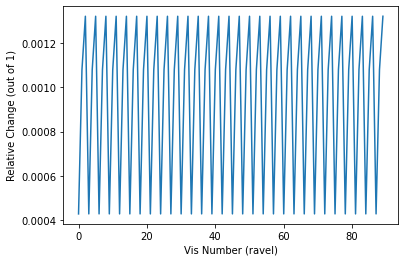

In [56]:
plt.figure()
plt.plot(abs_dif)
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Relative Change (out of 1)')

### Create Image Using ngCASA

In [57]:
#from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_image
import dask
import dask.array as da

In [58]:
rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

In [59]:
#mxds = apply_flags(mxds, 'xds0', flags='FLAG')
mxds.attrs['xds1'] = mxds.attrs['xds0'].isel(pol=slice(0,1))
mxds.attrs['xds1']['DATA'] = xr.DataArray(da.from_array(vis_data[:,:,:,0][:,:,:,None],chunks=mxds.attrs['xds1']['DATA'].chunks),coords=mxds.attrs['xds1']['DATA'].coords)

In [60]:
imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

In [61]:
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 0

In [62]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [20,20]
grid_parms['phase_center'] = pointing_ra_dec[0,0,:]#mxds.FIELD.PHASE_DIR[0,0,:].data.compute()

In [63]:
mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


In [64]:
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 0

In [65]:
img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

In [66]:
img_xds = xr.Dataset() #empty dataset
img_xds = make_image(mxds, img_xds, grid_parms, vis_sel_parms, img_sel_parms)

######################### Start make_image #########################
Setting default image_center  to  [100 200]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out [' sum_weight ']  to  SUM_WEIGHT
Setting default data_group_out [' image ']  to  IMAGE
######################### Created graph for make_image #########################


In [67]:
#Select chan 1
chan = 1

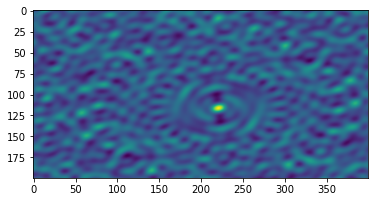

In [68]:
plt.figure()
plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))

### Calculate Pixel Position

In [40]:
phase_center = grid_parms['phase_center']
w = WCS(naxis=2)
w.wcs.crpix = np.array(grid_parms['image_size'])//2
w.wcs.cdelt = np.array([-20,20])*arcsec_to_deg
w.wcs.crval = phase_center*rad_to_deg
w.wcs.ctype = ['RA---SIN','DEC--SIN']

In [41]:
lm_pix_pos = w.all_world2pix(point_source_ra_dec[0,:,:]*rad_to_deg, 1)
print('source pix pos',lm_pix_pos)

source pix pos [[116.16846152 221.01091901]]


In [42]:
cell_size = np.array(grid_parms['cell_size'])*arcsec_to_rad
cell_size[0] = -cell_size[0]
image_center = np.array(grid_parms['image_size'])//2
source_lm_pos = lm_pix_pos*cell_size - image_center*cell_size
print('source lm pos',source_lm_pos)

source lm pos [[-0.00156774  0.00203728]]


### Plot Primary Beam

In [20]:
from sirius._sirius_utils._make_pb_symmetric import _casa_airy_disk

In [23]:
grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = np.array([200,400])
grid_parms['cell_size'] = np.array([-20,20])*arcsec_to_rad
grid_parms['phase_center'] = pointing_ra_dec[0,0,:]
pol = [1]
grid_parms['image_center'] = grid_parms['image_size']//2

In [24]:
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy'
pb_parms['list_dish_diameters'] = [24.5]
pb_parms['list_blockage_diameters'] = [0.0]
pb_parms['ipower'] = 2

In [25]:
pb = _casa_airy_disk(freq_chan,pol,pb_parms,grid_parms)

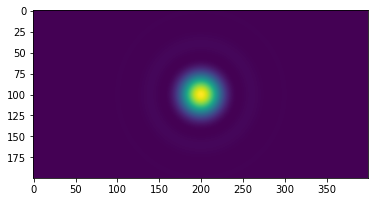

In [26]:
plt.figure()
plt.imshow(pb[:,:,1,0,0])

plt.show()